# Fitting with SVM Classifiers
Fit baseline and LDS data with `SVM`. Compare the results.

In [1]:
# import packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pickle
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn import svm

## Assistant Functions

In [2]:
def train_valid_split(data, predictor_names, tr_patients_ids, vld_patients_ids):
    
    """
    Split training and valid data according to
    corresponding indices of patient ids.
    
    @params: data: Dataframe, concatenated data of all patients
             predictor_names: List of Strings, names of all features
             tr_patients_ids: List of Strings, training patient ids
             vld_patients_ids: List of Strings, valid patient ids
    
    @return: Xtr, ytr, Xvld, yvld, Numpy Arrays, splitted training
             and valid data and corresponding labels.
    """
    
    # concatenate training and valid patient dataframes
    data_tr = data[data['patient_id'].isin(tr_patients_ids)]
    data_vld = data[data['patient_id'].isin(vld_patients_ids)]
    
    # define Xtr, ytr, Xvld, yvld
    Xtr = np.array(data_tr[predictor_names].values)
    ytr = data_tr['SepsisLabel'].values
    Xvld = np.array(data_vld[predictor_names].values)
    yvld = data_vld['SepsisLabel'].values
    
    return Xtr, ytr, Xvld, yvld

In [11]:
def plot_roc_auc(yvld, ns_probs, lr_probs):
    
    """
    plot roc and auc.
    
    @params: yvld: Numpy Array, valid or test labels
             ns_probs: Numpy Array, no skill probabilities (majority class)
             lr_probs: Numpy Array, probabilities of a class after fitting
    
    @return: None
    """
    
    # calculate scores
    ns_auc = roc_auc_score(yvld, ns_probs)
    lr_auc = roc_auc_score(yvld, lr_probs)
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(yvld, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(yvld, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area={0:.3f})'.format(ns_auc))
    plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM (area={0:.3f})'.format(lr_auc))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [10]:
def plot_precision_recall(yvld, precision, recall, probs, auc):
    
    """
    plot precision and recall.
    
    @params: yvld: Numpy Array, valid or test labels
             precision: Numpy Array, positive predictive value
             recall: Numpy Array, sensitivity
             probs: Numpy Array, probabilities of a class after fitting
             auc: Float, auc score
    
    @return: None
    """
    
    precision, recall, _ = precision_recall_curve(yvld, probs)
    # plot the precision-recall curves
    no_skill = len(yvld[yvld==1]) / len(yvld)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.',
             label='SVM=Max({0:.3f})'.format(np.unique(precision, axis=None)[-2]))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Load in baseline and LDS data

In [2]:
# read in baseline training and test data
with open('data_baseline.pickle', 'rb') as f1:
    training_baseline, test_baseline = pickle.load(f1)

# read in LDS training and test data
with open('data_LDS.pickle', 'rb') as f2:
    training_LDS, test_LDS = pickle.load(f2)

Split training and valid data `Xtr_baseline` and `Xvld_baseline`.

In [4]:
# list of unique num of patients
patients_baseline = list(np.unique(training_baseline['patient_id']))

# split train and valid as 70/30 ratio patient chunks
n_baseline = len(patients_baseline)
ntr_baseline = int(n_baseline * 0.7)
nvld_baseline = n_baseline - ntr_baseline

print('num total data:', n_baseline)
print('num training data:', ntr_baseline)
print('num test data:', nvld_baseline)

num total data: 20336
num training data: 14235
num test data: 6101


Split training and valid data `Xtr_LDS` and `Xvld_LDS`.

In [5]:
# list of unique num of patients
patients_LDS = list(np.unique(training_LDS['patient_id']))

# split train and valid as 70/30 ratio patient chunks
n_LDS = len(patients_LDS)
ntr_LDS = int(n_LDS * 0.7)
nvld_LDS = n_LDS - ntr_LDS

print('num total data:', n_LDS)
print('num training data:', ntr_LDS)
print('num test data:', nvld_LDS)

num total data: 20336
num training data: 14235
num test data: 6101


Create training list and valid list of patients `tr_patients_baseline` and `vld_patients_baseline`.

In [6]:
tr_patients_baseline = np.random.choice(patients_baseline, ntr_baseline, replace=False)
# randomly permute valid patient set
vld_patients_baseline = np.random.permutation(np.setdiff1d(patients_baseline, tr_patients_baseline))
print('training patients:', tr_patients_baseline)
print('valid patients:', vld_patients_baseline)

training patients: ['002350' '009753' '012082' ... '007178' '018060' '002793']
valid patients: ['003300' '002503' '018991' ... '011244' '002454' '014456']


In [7]:
# select the first 1000 patients from training set
# and first 200 from valid set and sort both arrays
# for faster fitting time of SVM
tr_patient_sub = np.sort(tr_patients_baseline[:1000])
vld_patient_sub = np.sort(vld_patients_baseline[:200])

# training and valid data
predictor_names = training_baseline.columns[1:-2]
Xtr_baseline, ytr_baseline, Xvld_baseline, yvld_baseline = train_valid_split(training_baseline,
                                                                             predictor_names,
                                                                             tr_patient_sub,
                                                                             vld_patient_sub)

Create training list and valid list of patients `tr_patients_LDS` and `vld_patients_LDS`.

In [8]:
tr_patients_LDS = np.random.choice(patients_LDS, ntr_LDS, replace=False)
# randomly permute valid patient set
vld_patients_LDS = np.random.permutation(np.setdiff1d(patients_LDS, tr_patients_LDS))
print('training patients:', tr_patients_LDS)
print('valid patients:', vld_patients_LDS)

training patients: ['012669' '016563' '010339' ... '019903' '001274' '015594']
valid patients: ['013983' '003366' '016534' ... '003388' '003431' '019337']


In [9]:
# select the first 1000 patients from training set
# and first 200 from valid set and sort both arrays
# for faster fitting time of SVM
tr_patient_sub_LDS = np.sort(tr_patients_LDS[:1000])
vld_patient_sub_LDS = np.sort(vld_patients_LDS[:200])

# training and valid data
predictor_names_LDS = training_LDS.columns[1:-2]
Xtr_LDS, ytr_LDS, Xvld_LDS, yvld_LDS = train_valid_split(training_LDS,
                                                         predictor_names_LDS,
                                                         tr_patient_sub_LDS,
                                                         vld_patient_sub_LDS)

Scale data using `StandardScaler` before training.

In [10]:
scaler_baseline = preprocessing.StandardScaler()
scaler_baseline.fit(Xtr_baseline)
Xtr_baseline = scaler_baseline.transform(Xtr_baseline)
Xvld_baseline = scaler_baseline.transform(Xvld_baseline)

In [11]:
scaler_LDS = preprocessing.StandardScaler()
scaler_LDS.fit(Xtr_baseline)
Xtr_LDS = scaler_LDS.transform(Xtr_LDS)
Xvld_LDS = scaler_LDS.transform(Xvld_LDS)

## Train SVM model
Train `SVM` models separately on baseline and LDS data.

### Run SVM on baseline

First create the SVM classifer. Use an `linear` classifier with `C=2.8` and `gamma=.0073`.

In [12]:
svc_baseline = svm.SVC(probability=True,  kernel="linear", C=2.8, gamma=.0073, verbose=10)

Fit the classifier using the scaled training data.

In [13]:
svc_baseline.fit(Xtr_baseline, ytr_baseline)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=10)

Measure the accuracy on the valid data.

In [14]:
yhat_baseline = svc_baseline.predict(Xvld_baseline)
print(np.mean(yhat_baseline == yvld_baseline))

0.9809424357133534


Plot AUROC curve and PR curve of baseline.

/Users/erinhu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


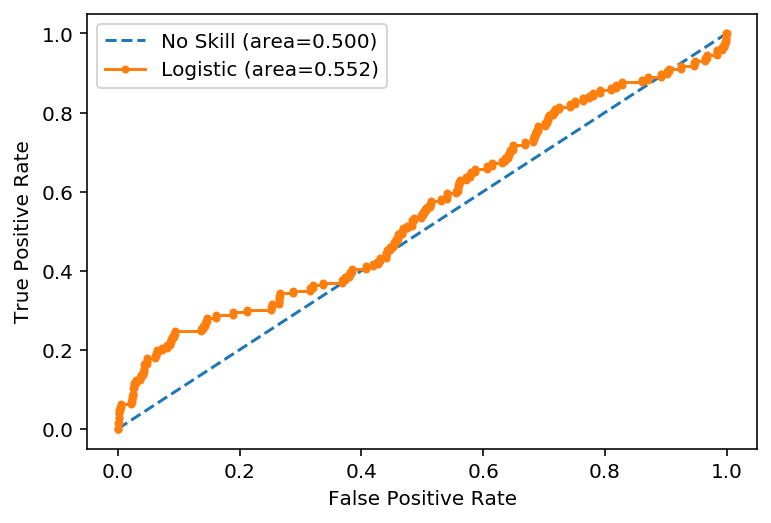

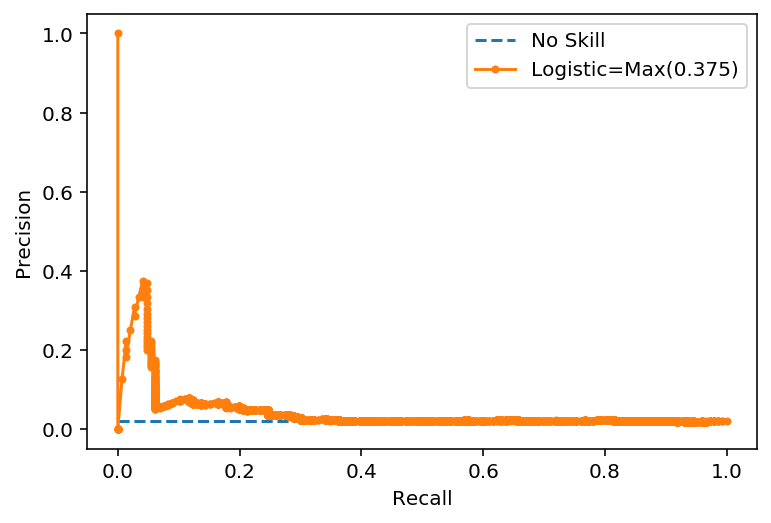

avg. precision: 0.027396240198873614
avg. recall: 0.550597592448751
avg. f: 0.04606250135053044
auc: 0.04158513746580798


/Users/erinhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [3]:
ns_probs = [0 for _ in range(len(yvld_baseline))]       # generate a no skill prediction (majority class)
svm_probs = svc_baseline.predict_proba(Xvld_baseline)[:, 1]    # keep probabilities for the positive outcome only
svm_auc = roc_auc_score(yvld_baseline, svm_probs)

# Measure the precision, recall and f1-score.
preci, reci, f1i, _= precision_recall_fscore_support(yvld_baseline, yhat_baseline, average='binary') 

plot_roc_auc(yvld_baseline, ns_probs, svm_probs)
plot_precision_recall(yvld_baseline, preci, reci, svm_probs, svm_auc)

precision, recall, _ = precision_recall_curve(yvld_baseline, svm_probs)
print('avg. precision:', np.mean(precision))
print('avg. recall:', np.mean(recall))
print('avg. f:', np.nanmean(2 * (precision * recall) / (precision + recall)))
print('auc:', auc(recall, precision))

### Run SVM on LDS

First create the SVM classifer. Use an `linear` classifier with `C=2.8` and `gamma=.0073`.

In [16]:
svc_LDS = svm.SVC(probability=True,  kernel="linear", C=2.8, gamma=.0073, verbose=10)

Fit the classifier using the scaled training data.

In [17]:
svc_LDS.fit(Xtr_LDS, ytr_LDS)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=10)

Measure the accuracy on the valid data.

In [18]:
yhat_LDS = svc_LDS.predict(Xvld_LDS)
print(np.mean(yhat_LDS == yvld_LDS))

0.9837968869609595


Plot AUROC curve and PR curve of LDS.

/Users/erinhu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


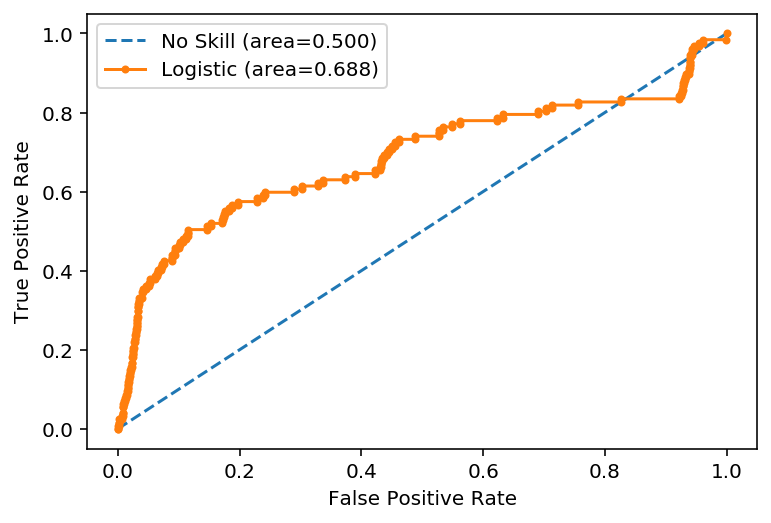

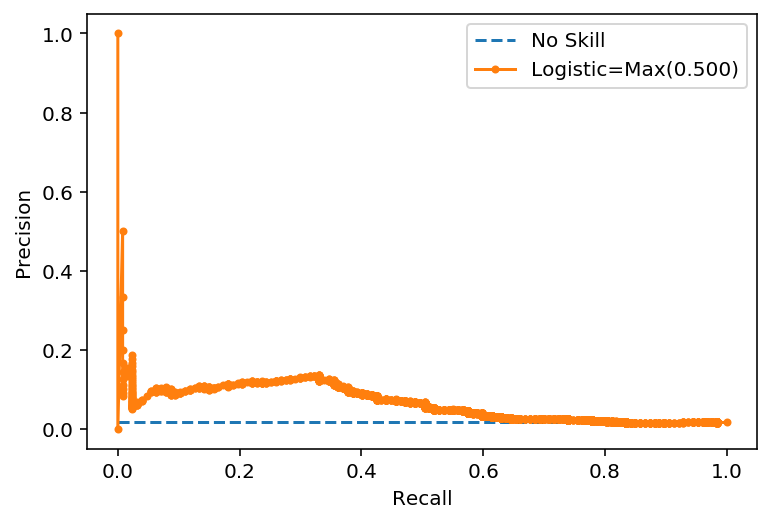

avg. precision: 0.034250917900402536
avg. recall: 0.6844625117457002
avg. f: 0.059119178075062964
auc: 0.06516095579131201


/Users/erinhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [4]:
ns_probs = [0 for _ in range(len(yvld_LDS))]       # generate a no skill prediction (majority class)
svm_probs = svc_LDS.predict_proba(Xvld_LDS)[:, 1]    # keep probabilities for the positive outcome only
svm_auc = roc_auc_score(yvld_LDS, svm_probs)

# Measure the precision, recall and f1-score.
preci, reci, f1i, _= precision_recall_fscore_support(yvld_LDS, yhat_LDS, average='binary') 

plot_roc_auc(yvld_LDS, ns_probs, svm_probs)
plot_precision_recall(yvld_LDS, preci, reci, svm_probs, svm_auc)

precision, recall, _ = precision_recall_curve(yvld_LDS, svm_probs)
print('avg. precision:', np.mean(precision))
print('avg. recall:', np.mean(recall))
print('avg. f:', np.nanmean(2 * (precision * recall) / (precision + recall)))
print('auc:', auc(recall, precision))

## Predict test data

### Predict on baseline

Separate test predictors `Xts_baseline` and test labels `yts_baseline`.

In [20]:
Xts_baseline = np.array(test_baseline[predictor_names].values)
yts_baseline = test_baseline['SepsisLabel'].values

Xts_baseline = scaler_baseline.transform(Xts_baseline)

Measure the accuracy on the test data.

In [21]:
ts_yhat_baseline = svc_baseline.predict(Xts_baseline)
print(np.mean(ts_yhat_baseline == yts_baseline))

0.9858529255441308


Plot AUROC curve and PR curve of baseline.

/Users/erinhu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


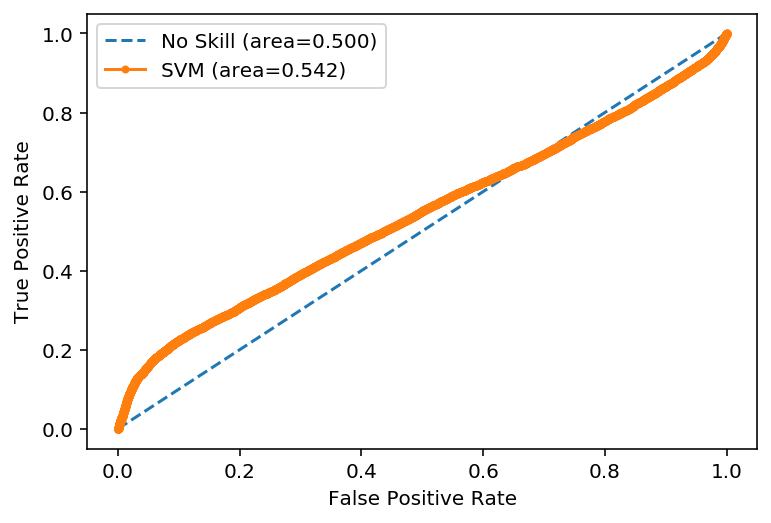

/Users/erinhu/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


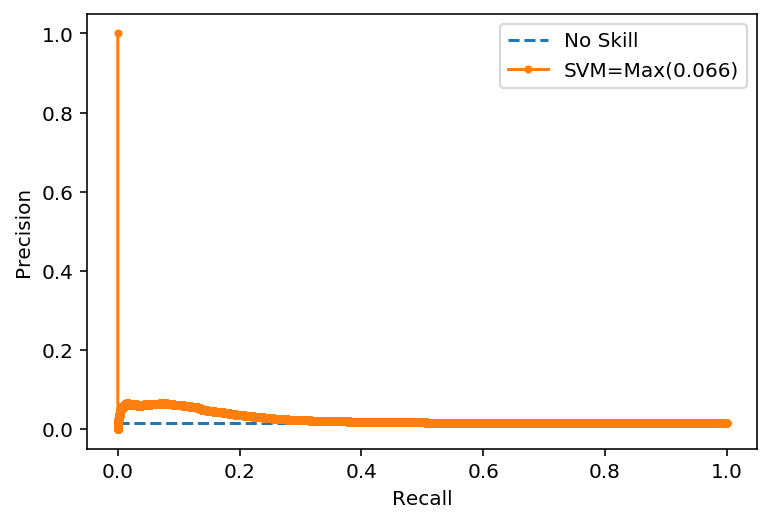

In [14]:
ns_probs = [0 for _ in range(len(yts_baseline))]       # generate a no skill prediction (majority class)
svm_probs = svc_baseline.predict_proba(Xts_baseline)[:, 1]    # keep probabilities for the positive outcome only
svm_auc = roc_auc_score(yts_baseline, svm_probs)

# Measure the precision, recall and f1-score.
preci, reci, f1i, _= precision_recall_fscore_support(yts_baseline, ts_yhat_baseline, average='binary') 

plot_roc_auc(yts_baseline, ns_probs, svm_probs)
plot_precision_recall(yts_baseline, preci, reci, svm_probs, svm_auc)

### Predict on LDS

Separate test predictors `Xts_LDS` and test labels `yts_LDS`.

In [23]:
Xts_LDS = np.array(test_LDS[predictor_names_LDS].values)
yts_LDS = test_LDS['SepsisLabel'].values

Xts_LDS = scaler_LDS.transform(Xts_LDS)

Measure the accuracy on the test data.

In [24]:
ts_yhat_LDS = svc_LDS.predict(Xts_LDS)
print(np.mean(ts_yhat_LDS == yts_LDS))

0.9854455219021137


Plot AUROC curve and PR curve of LDS.

/Users/erinhu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


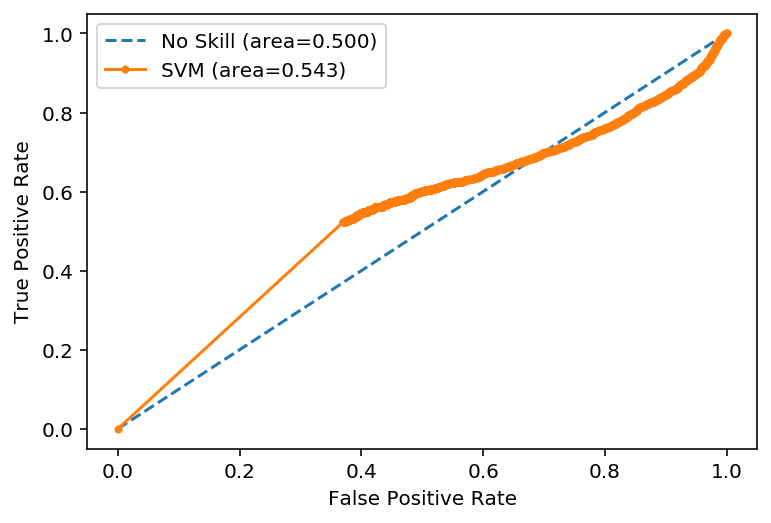

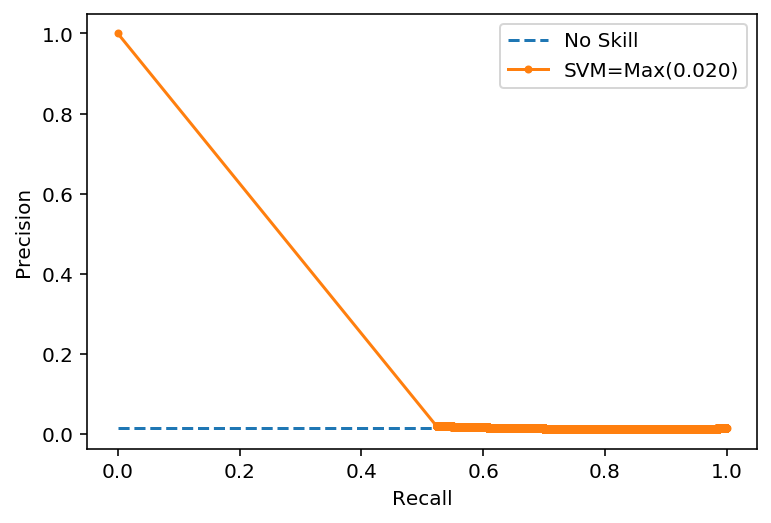

In [15]:
ns_probs = [0 for _ in range(len(yts_LDS))]       # generate a no skill prediction (majority class)
svm_probs = svc_baseline.predict_proba(Xts_LDS)[:, 1]    # keep probabilities for the positive outcome only
svm_auc = roc_auc_score(yts_LDS, svm_probs)

# Measure the precision, recall and f1-score.
preci, reci, f1i, _= precision_recall_fscore_support(yts_LDS, ts_yhat_LDS, average='binary') 

plot_roc_auc(yts_LDS, ns_probs, svm_probs)
plot_precision_recall(yts_LDS, preci, reci, svm_probs, svm_auc)

In [2]:
dill.load_session('baseline_LDS_other_complete.db')